# KVLCC2 geometry analysis

# Purpose
Analyse the geometry section by section

# Methodology
Load offset points from Rhino

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

#%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

#from jupyterthemes import jtplot
#jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from reports.paper_writing import save_fig

In [3]:
db = database.get_db()

sql = """
SELECT * from run
INNER JOIN loading_conditions
ON (run.loading_condition_id = loading_conditions.id)
INNER JOIN models
ON (run.model_number = models.model_number)
INNER JOIN ships
ON (run.ship_name = ships.name)
WHERE run.model_number='M5057-01-A' and run.test_type='roll decay' and run.project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine)
df_rolldecays['rho']=1000
df_rolldecays['g']=9.81
df_rolldecays=df_rolldecays.loc[:,~df_rolldecays.columns.duplicated()]
df_rolldecays.set_index('id', inplace=True)

In [4]:
df_rolldecays.head()

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,rho,g
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,NaN,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1000,9.81
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,NaN,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1000,9.81
21339,40178362,1,96,1,M5057-01-A,M5057-01-A,166,96.0,NaN,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-11-28,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1000,9.81
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,None,None,None,20.8,11.2672,18.6,5.73,None,20.8,20.8,None,23.2,80.0,None,None,312653.0,0.99538,None,68.0,320.0,58.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1000,9.81


In [5]:
loading_condition = df_rolldecays.loc[21340]
#print(loading_condition.project_path)

In [6]:
loading_condition.TA

20.8

In [7]:
loading_condition.TF

20.8

In [8]:
loading_condition.lpp

320.0

In [9]:
draught = (loading_condition.TA + loading_condition.TF)/2

In [10]:
file_path = r'S:/2020/40209514-DEMOPS/03_Project/020_PROJECT_MANAGEMENT/arbetsmapp/ISOPE/KVLCC2_points.txt'
points = pd.read_csv(file_path, sep=';', header=None)
points.columns = ['x','y','z']
points.describe()

,x,y,z
count,7140.000000,7140.000000,7.140000e+03
mean,157.454893,17.750299,7.740190e+00
std,110.633263,10.884987,9.114148e+00
min,-5.495000,-0.000173,-2.220446e-16
25%,48.179054,6.451813,8.789816e-01
50%,153.290740,22.257320,3.160564e+00
75%,264.429320,27.889503,1.273352e+01
max,327.995000,29.000004,4.000111e+01


<IPython.core.display.Javascript object>


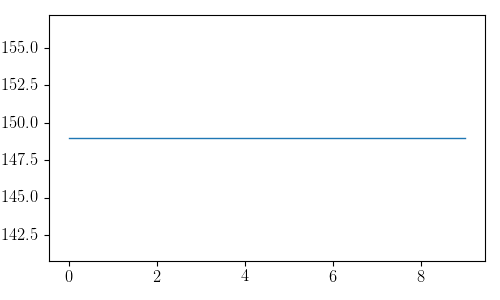

In [11]:
ns = np.arange(10)
n_sections = []
for n in ns:
    n_sections.append( len(points['x'].round(decimals=n).unique()))

fig,ax=plt.subplots()
ax.plot(ns,n_sections)

In [12]:
points['x'] = points['x'].round(decimals=6)
points['z'] = points['z'].round(decimals=2)
x = points['x'].unique()
x_groups = points.groupby(by='x')
points2 = x_groups.filter(lambda x:x['x'].count() > 2)
x = points2['x'].unique()
x_groups = points2.groupby(by='x')

<IPython.core.display.Javascript object>


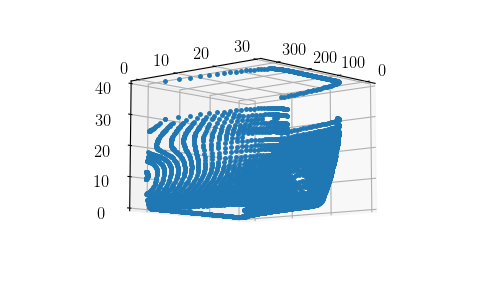

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(points['x'], points['y'], points['z'], '.')

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


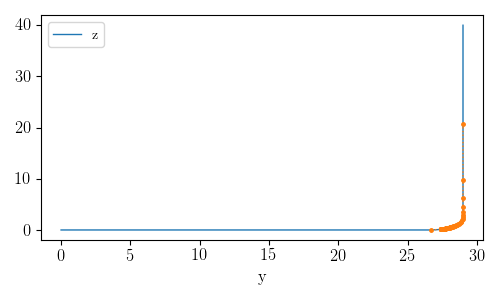

In [14]:

N = 100
z_ = np.linspace(0,1,N)**-1.1
z_ = z_/z_[1]
z = draught*z_[1:]
z = np.concatenate((z,[0]))
z = np.flipud(z)


section = x_groups.get_group(x[int(len(x)/2)])
section.sort_values(by='z', inplace=True)
y = np.interp(z, section['z'], section['y'])
    

fig,ax=plt.subplots()
section.plot(x='y', y='z', ax=ax)
ax.plot(y,z,'.:')

<IPython.core.display.Javascript object>


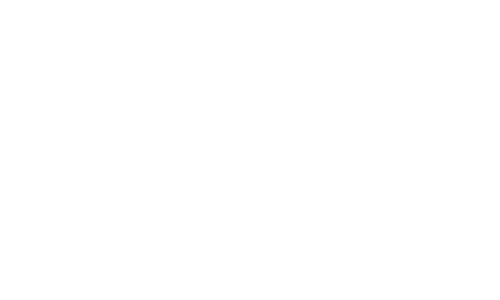

In [15]:
data = {
    'y':[3,2,1],
    'z':[5,3,2],
}
section = pd.DataFrame(data=data)

fig,ax=plt.subplots()
section.plot(x='y', y='z', style = 'ko-', label='original', ax=ax)

xy = section[['y','z']].values.tolist()


if xy[-1][0] > 0:
    centre_end_point = [0,xy[-1][1]]
    xy.append(centre_end_point)  # Adding missing centre end point

if xy[0][1] < draught:
    water_line_point_1 = [xy[0][0],draught]
    xy.insert(0,water_line_point_1)  # Adding missing water line point

top_centre_point = [0,xy[0][1]]
xy.insert(0,top_centre_point)

close_point = xy[-1]
xy.insert(0,close_point)
xy = np.array(xy)

ax.plot(xy[:,0], xy[:,1],'--')
ax.plot(*centre_end_point, 'ro', label='centre end point')
ax.plot(*water_line_point_1, 'bo', label='water_line_point_1')
ax.plot(*top_centre_point, 'yo', label='top_centre_point')
ax.plot(*close_point, 'ro', label='close_point')

ax.legend()



In [16]:
def close_section(section):
         
    """
    The sections are defined as:
    (y,z):
            0
            1
            2
            3
           4
    5
    """
    xy = section[['y','z']].values.tolist()

    if xy[-1][0] > 0:
        centre_end_point = [0,xy[-1][1]]
        xy.append(centre_end_point)  # Adding missing centre end point
    
    if xy[0][1] < draught:
        water_line_point_1 = [xy[0][0],draught]
        xy.insert(0,water_line_point_1)  # Adding missing water line point
    
    top_centre_point = [0,xy[0][1]]
    xy.insert(0,top_centre_point)
    
    close_point = xy[-1]
    xy.insert(0,close_point)
    xy = np.array(xy)
    
    closed_section = pd.DataFrame()
    closed_section['y'] = xy[:,0]
    closed_section['z'] = xy[:,1]
    closed_section['x'] = section.iloc[0].x
        
    return closed_section
    

In [17]:
x_groups = points.groupby(by='x')
N = 100
z_ = np.linspace(0,1,N)**-1.1
z_ = z_/z_[1]
z = draught*z_[1:]
z = np.concatenate((z,[0]))
z = np.flipud(z)

df_sections = pd.DataFrame()

for i,(x_, section) in enumerate(x_groups):
    #section.sort_values(by='z', inplace=True)
    mask = section['z'] <= draught   
    section = section.loc[mask]
    if len(section)==0:
        continue
    
    new_section = pd.DataFrame()
    new_section['y']=section['y']
    new_section['x']=x_
    new_section['z']=section['z']
    new_closed_section = close_section(new_section)
    new_closed_section['no']=i
    df_sections = df_sections.append(new_closed_section)
    

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df_sections.head()

,y,z,x,no
0,-9.001914e-15,18.80,-5.495,0
1,0.000000e+00,20.80,-5.495,0
2,5.819288e+00,20.80,-5.495,0
3,5.819288e+00,20.75,-5.495,0
4,5.198539e+00,20.43,-5.495,0


In [19]:
def poly_area(xy):
    """ 
        Calculates polygon area using Greens formula.
        x = xy[:,0], y = xy[:,1]
    """
    xy1 = np.roll(xy,-1,axis = 0) # shift by -1
    return -0.5*np.inner(xy1[:,0] - xy[:,0],xy1[:,1] + xy[:,1])

def section_area(section):
    xy = section[['y','z']].values
    return np.abs(poly_area(xy=xy))

In [20]:
df_sections['x'].unique()

array([ -5.495   ,  -3.258581,  -1.022162,   1.214257,   3.450676,
         5.687095,   7.923513,  10.159932,  12.396351,  14.63277 ,
        16.869189,  19.105608,  21.342027,  23.578446,  25.814865,
        28.051284,  30.287703,  32.524122,  34.760541,  36.996959,
        39.233378,  41.469797,  43.706216,  45.942635,  48.179054,
        50.415473,  52.651892,  54.888311,  57.12473 ,  59.361149,
        61.597568,  63.833986,  66.070405,  68.306824,  70.543243,
        72.779662,  75.016081,  77.2525  ,  79.488919,  81.725338,
        83.961757,  86.198176,  88.434595,  90.671014,  92.907432,
        95.143851,  97.38027 ,  99.616689, 101.85311 , 104.08953 ,
       106.32595 , 108.56236 , 110.79878 , 113.0352  , 115.27162 ,
       117.50804 , 119.74446 , 121.98088 , 124.2173  , 126.45372 ,
       128.69014 , 130.92655 , 133.16297 , 135.39939 , 137.63581 ,
       139.87223 , 142.10865 , 144.34507 , 146.58149 , 148.81791 ,
       151.05432 , 153.29074 , 155.52716 , 157.76358 , 160.   

<IPython.core.display.Javascript object>


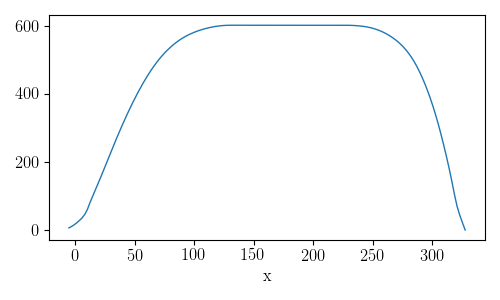

<AxesSubplot:xlabel='x'>

In [21]:
sections = df_sections.groupby(by='x')
areas = sections.apply(func=section_area)
fig,ax=plt.subplots()
areas.plot(ax=ax)

In [22]:
min_area = 1
df_sections2 = sections.filter(func=lambda x : section_area(x) > min_area)
sections = df_sections2.groupby(by='x')

<IPython.core.display.Javascript object>


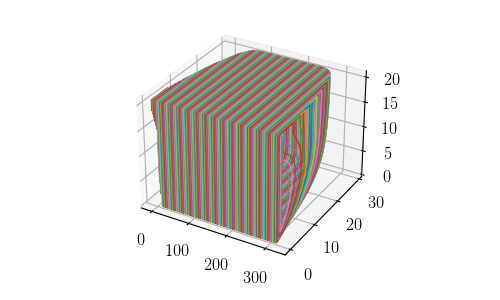

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for no,section, in sections:
    
    ax.plot(section['x'], section['y'], section['z'])

In [24]:
x_interps = np.linspace(df_sections2['x'].min(), df_sections2['x'].max(),21)
xs = df_sections2['x'].unique()
x_ = []
for x_interp in x_interps:
    i = np.argmin(np.abs(x_interp - xs))
    x_.append(xs[i])
    
df_sections3 = pd.DataFrame()
for i,x in enumerate(x_):
    section = sections.get_group(x)
    section['no'] = i
    df_sections3 = df_sections3.append(section)

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


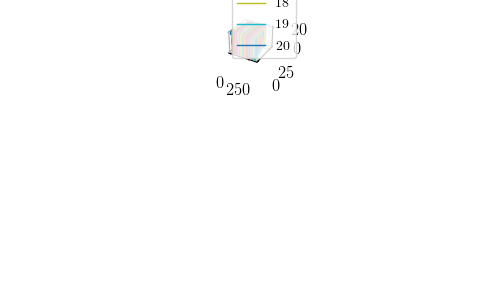

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sections2 = df_sections3.groupby(by='no')
for no, section in sections2:
    
    ax.plot(section['x'], section['y'], section['z'], label=no)
    
ax.legend()

<IPython.core.display.Javascript object>


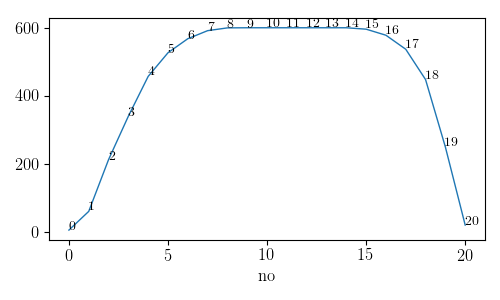

In [26]:
areas2 = sections2.apply(section_area)
fig,ax=plt.subplots()
areas2.plot(ax=ax)
for no,a in areas2.items():
    ax.annotate(no,xy=(no,a))

In [27]:
def estimate_bilge_radius(section):
    b = section['b']  
    t = section['t']
    A = section['area']  
    r = np.sqrt(4/np.pi*(b*t-A))
    return r

def section_data(section):
    
    s = pd.Series()
    s.name=section.name
    s['area'] = 2*section_area(section) # two sides
    s['x'] = section.iloc[0].x
    s['t'] = section.z.max() - section.z.min()
    s['b'] = 2*section.y.max()  # two sides
    s['r_b'] = estimate_bilge_radius(s)
    
    return s
    

In [28]:
df_section_properties = sections2.apply(func=section_data)

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


In [29]:
df_section_properties.to_csv('../data/interim/kvlcc_areas.csv', sep=';')

In [30]:
df_section_properties

,area,x,t,b,r_b
no,,,,,
0,13.826612,-5.495000,2.00,11.638577,3.468833
1,123.851306,10.159932,18.25,27.893522,22.146305
2,428.211409,28.051284,20.80,41.824284,23.715666
3,683.709165,43.706216,20.80,50.282514,21.473833
4,917.895066,61.597568,20.80,56.159232,17.848981
5,1056.860933,77.252500,20.80,57.870498,13.673676
6,1139.503552,92.907432,20.80,58.000008,9.229053
7,1186.852794,110.798780,20.80,58.000008,4.988836
8,1203.217372,126.453720,20.80,58.000008,2.013072


<IPython.core.display.Javascript object>


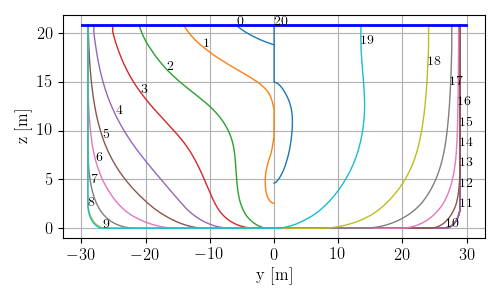

In [31]:
fig,ax = plt.subplots()

zmax = sections2['z'].max().max()
for no,section, in sections2:
    
    section = section.iloc[2:]  # Removing close
    
    y = section['z']
        
    if no < 10:
        n = no
        x = -section['y']
        y_text = zmax - n*(zmax/9) 
    else:
        n = 20 - no
        x = section['y']
        y_text = zmax - n*(zmax/10) 

    x_text = np.interp(y_text,np.flipud(y),np.flipud(x))
        
    ax.plot(x, y)
    ax.annotate(no,xy=(x_text,y_text))

ymax = sections2['y'].max().max()
ax.plot(1.03*np.array([-ymax,ymax]),[zmax,zmax],'b-', lw=2)
ax.set_xlabel('y [m]')
ax.set_ylabel('z [m]')
ax.grid(True)
save_fig(fig, name='KVLCC2_body_plan')

<IPython.core.display.Javascript object>


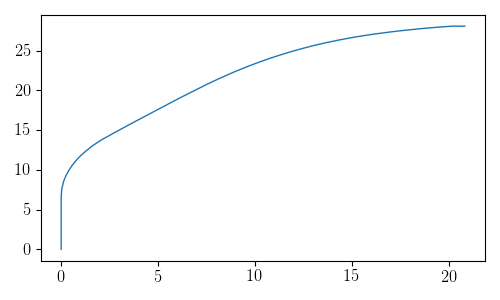

28.079615999999998

In [32]:
section = sections2.get_group(4)
section = section.iloc[2:]
y = section['z']
n = 20 - no
x = section['y']    

fig,ax=plt.subplots()
ax.plot(y,x)

np.interp(y_text,np.flipud(y),np.flipud(x))